# Exploration Notebook

This notebook is heavily inspired by the kernel [https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart) (some would even call it stealing :) )

## Instacart Market Basket Analysis

An introduction to the Instacart Market Basket Analysis competition can be found on the official [Kaggle site](https://www.kaggle.com/c/instacart-market-basket-analysis) or this [blog post](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2).

##### Description
> In this competition, Instacart is challenging the Kaggle community to use this anonymized data on customer orders over time to predict which previously purchased products will be in a user’s next order. They’re not only looking for the best model, Instacart’s also looking for machine learning engineers to grow their team.

##### Scoring
Submissions will be evaluated based on their mean [F1 score](https://en.wikipedia.org/wiki/F1_score) (Harmonic mean of precision and recall) and is given by

$$
F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$


The submission should be on the form
```
order_id,products  
17,1 2  
34,None  
137,1 2 3  
etc.

```
where the products only include re-orderd products as specified in the description.

## Data

We start by importing the nessecary libraries and data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
color = sns.color_palette()
fs = 14

%matplotlib inline

# Folder with competition data
data_dir = 'data'

# Matplotlib function
def annotate_bars(ax,fontsize=12,offset=0):
    '''
    Function to get annotated bars for matplotlib
    '''
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
            height + offset,
            '{:1.0f}'.format(height),
            ha="center",fontsize=fontsize)

Let's see what files we have in our data folder (you can download the competition data from [this](https://www.kaggle.com/c/instacart-market-basket-analysis/data) page).

In [2]:
from subprocess import check_output
print(check_output(["ls", data_dir]).decode("utf8"))

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



In [3]:
order_products_train_df = pd.read_csv(data_dir + "/order_products__train.csv")
order_products_prior_df = pd.read_csv(data_dir + "/order_products__prior.csv")
orders_df = pd.read_csv(data_dir + "/orders.csv")
products_df = pd.read_csv(data_dir + "/products.csv")
aisles_df = pd.read_csv(data_dir + "/aisles.csv")
departments_df = pd.read_csv(data_dir + "/departments.csv")

We see that we have 7 files. We exlude the submission file at the moment, and take a closer look at the following data files:
* **Orders** (orders.csv)
* **Orders prior** (order_products_prior.csv)
* **Orders train** (order_products_train.csv)
* **Products** (products.csv)
* **Aisles** (aisles.csv)
* **Departments** (departments.csv)

In [4]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


The data in **orders_df** includes all the orders from customers.

In [5]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


**order_products_train** includes the products of the orders in the training data, while **order_products_prior** includes all the products that are neither in the training data or the test data.

In [7]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


We see that **products_df** includes product ID, product name, aisle ID and department ID

In [8]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


**aisles_df** includes aisle ID and aisle name.

In [9]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


**departments_df** includes department ID and department name.

To make the data easier to work with, we merge the order_products_df with products, aisles and departments.

In [10]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [11]:
order_products_train_df = pd.merge(order_products_train_df, products_df, on='product_id', how='left')
order_products_train_df = pd.merge(order_products_train_df, aisles_df, on='aisle_id', how='left')
order_products_train_df = pd.merge(order_products_train_df, departments_df, on='department_id', how='left')
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


To simplify, we drop the IDs for product, aisle and department

In [12]:
order_products_prior_df = order_products_prior_df.drop(["product_id","aisle_id","department_id"],axis=1)
order_products_train_df = order_products_train_df.drop(["product_id","aisle_id","department_id"],axis=1)
order_products_train_df.head()

,order_id,add_to_cart_order,reordered,product_name,aisle,department
0,1,1,1,Bulgarian Yogurt,yogurt,dairy eggs
1,1,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,other creams cheeses,dairy eggs
2,1,3,0,Organic Celery Hearts,fresh vegetables,produce
3,1,4,0,Cucumber Kirby,fresh vegetables,produce
4,1,5,1,Lightly Smoked Sardines in Olive Oil,canned meat seafood,canned goods


Now it is much simpler to understand the structure of the data. We see that order 1 have several items including Bulgarian Yoghurt, Cottage Cheese etc.

Now, we only need to worry about 3 data frames:
* **order_products_prior_df**
* **order_products_train_df**
* **orders_df**

## Introduction to how the competition works

The construction of prior-, train and test data seems a bit complicated. Let's deep-dive into a single customer to see how it works

In [15]:
order_ids = orders_df[orders_df.user_id==1]['order_id']
orders_df[orders_df.user_id==1]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


For each user user, **Instacart provides between 4 and 10 orders**. We see that this example customer have 11 orders where the last one is included in the training set and the rest in the prior set (Similarly, we will find other customers where the last order is in the test set and the rest of the orders are in the prior set).

Let's print out the market baskets for these 11 orders.

In [16]:
for n in range(len(order_ids)-1):
    display(HTML("<br><b>Order number: " + str(n) + "</b>"))
    display(order_products_prior_df[order_products_prior_df.order_id == order_ids[n]])

display(HTML("<br><b>Order number: " + str(n+1) + "</b>"))
display(order_products_train_df[order_products_train_df.order_id == order_ids[len(order_ids)-1]])

,order_id,add_to_cart_order,reordered,product_name,aisle,department
24076664,2539329,1,0,Soda,soft drinks,beverages
24076665,2539329,2,0,Organic Unsweetened Vanilla Almond Milk,soy lactosefree,dairy eggs
24076666,2539329,3,0,Original Beef Jerky,popcorn jerky,snacks
24076667,2539329,4,0,Aged White Cheddar Popcorn,popcorn jerky,snacks
24076668,2539329,5,0,XL Pick-A-Size Paper Towel Rolls,paper goods,household


,order_id,add_to_cart_order,reordered,product_name,aisle,department
22742744,2398795,1,1,Soda,soft drinks,beverages
22742745,2398795,2,0,Pistachios,nuts seeds dried fruit,snacks
22742746,2398795,3,1,Original Beef Jerky,popcorn jerky,snacks
22742747,2398795,4,0,Bag of Organic Bananas,fresh fruits,produce
22742748,2398795,5,1,Aged White Cheddar Popcorn,popcorn jerky,snacks
22742749,2398795,6,0,Cinnamon Toast Crunch,cereal,breakfast


,order_id,add_to_cart_order,reordered,product_name,aisle,department
4488095,473747,1,1,Soda,soft drinks,beverages
4488096,473747,2,1,Original Beef Jerky,popcorn jerky,snacks
4488097,473747,3,1,Pistachios,nuts seeds dried fruit,snacks
4488098,473747,4,0,Organic String Cheese,packaged cheese,dairy eggs
4488099,473747,5,0,Creamy Almond Butter,spreads,pantry


,order_id,add_to_cart_order,reordered,product_name,aisle,department
21376074,2254736,1,1,Soda,soft drinks,beverages
21376075,2254736,2,1,Original Beef Jerky,popcorn jerky,snacks
21376076,2254736,3,1,Pistachios,nuts seeds dried fruit,snacks
21376077,2254736,4,1,Organic String Cheese,packaged cheese,dairy eggs
21376078,2254736,5,1,XL Pick-A-Size Paper Towel Rolls,paper goods,household


,order_id,add_to_cart_order,reordered,product_name,aisle,department
4089398,431534,1,1,Soda,soft drinks,beverages
4089399,431534,2,1,Original Beef Jerky,popcorn jerky,snacks
4089400,431534,3,1,Pistachios,nuts seeds dried fruit,snacks
4089401,431534,4,1,Organic String Cheese,packaged cheese,dairy eggs
4089402,431534,5,0,Organic Fuji Apples,fresh fruits,produce
4089403,431534,6,0,Honeycrisp Apples,fresh fruits,produce
4089404,431534,7,0,Bartlett Pears,fresh fruits,produce
4089405,431534,8,1,Bag of Organic Bananas,fresh fruits,produce


,order_id,add_to_cart_order,reordered,product_name,aisle,department
31927070,3367565,1,1,Soda,soft drinks,beverages
31927071,3367565,2,1,Original Beef Jerky,popcorn jerky,snacks
31927072,3367565,3,1,Pistachios,nuts seeds dried fruit,snacks
31927073,3367565,4,1,Organic String Cheese,packaged cheese,dairy eggs


,order_id,add_to_cart_order,reordered,product_name,aisle,department
5212927,550135,1,1,Soda,soft drinks,beverages
5212928,550135,2,1,Pistachios,nuts seeds dried fruit,snacks
5212929,550135,3,1,Original Beef Jerky,popcorn jerky,snacks
5212930,550135,4,1,Organic String Cheese,packaged cheese,dairy eggs
5212931,550135,5,1,Cinnamon Toast Crunch,cereal,breakfast


,order_id,add_to_cart_order,reordered,product_name,aisle,department
29474805,3108588,1,1,Original Beef Jerky,popcorn jerky,snacks
29474806,3108588,2,1,Soda,soft drinks,beverages
29474807,3108588,3,1,Pistachios,nuts seeds dried fruit,snacks
29474808,3108588,4,1,Organic String Cheese,packaged cheese,dairy eggs
29474809,3108588,5,0,Zero Calorie Cola,soft drinks,beverages
29474810,3108588,6,0,Organic Half & Half,cream,dairy eggs


,order_id,add_to_cart_order,reordered,product_name,aisle,department
21760443,2295261,1,1,Organic Half & Half,cream,dairy eggs
21760444,2295261,2,1,Zero Calorie Cola,soft drinks,beverages
21760445,2295261,3,1,Organic String Cheese,packaged cheese,dairy eggs
21760446,2295261,4,1,Soda,soft drinks,beverages
21760447,2295261,5,1,Pistachios,nuts seeds dried fruit,snacks
21760448,2295261,6,1,Original Beef Jerky,popcorn jerky,snacks


,order_id,add_to_cart_order,reordered,product_name,aisle,department
24181266,2550362,1,1,Soda,soft drinks,beverages
24181267,2550362,2,1,Zero Calorie Cola,soft drinks,beverages
24181268,2550362,3,0,Milk Chocolate Almonds,candy chocolate,snacks
24181269,2550362,4,0,0% Greek Strained Yogurt,yogurt,dairy eggs
24181270,2550362,5,1,Organic String Cheese,packaged cheese,dairy eggs
24181271,2550362,6,1,Pistachios,nuts seeds dried fruit,snacks
24181272,2550362,7,0,Organic Unsweetened Almond Milk,soy lactosefree,dairy eggs
24181273,2550362,8,1,Cinnamon Toast Crunch,cereal,breakfast
24181274,2550362,9,1,Original Beef Jerky,popcorn jerky,snacks


,order_id,add_to_cart_order,reordered,product_name,aisle,department
484420,1187899,1,1,Soda,soft drinks,beverages
484421,1187899,2,1,Organic String Cheese,packaged cheese,dairy eggs
484422,1187899,3,1,0% Greek Strained Yogurt,yogurt,dairy eggs
484423,1187899,4,1,XL Pick-A-Size Paper Towel Rolls,paper goods,household
484424,1187899,5,1,Milk Chocolate Almonds,candy chocolate,snacks
484425,1187899,6,1,Pistachios,nuts seeds dried fruit,snacks
484426,1187899,7,1,Cinnamon Toast Crunch,cereal,breakfast
484427,1187899,8,1,Aged White Cheddar Popcorn,popcorn jerky,snacks
484428,1187899,9,0,Organic Whole Milk,milk,dairy eggs
484429,1187899,10,1,Organic Half & Half,cream,dairy eggs


We see that the market baskets gives us information about the different products, in additition to specifiying the add-to-cart-order and whether the product is reordered or not.

Given this sample, **we want to train a classifier that given order 0-9 is able to predict the re-ordered products of order 10.**

## Data analysis

### Orders
Let's start to dig deeper into the data. First, we look at the number of orders in the prior-, train- and test data.

(0, 3500)

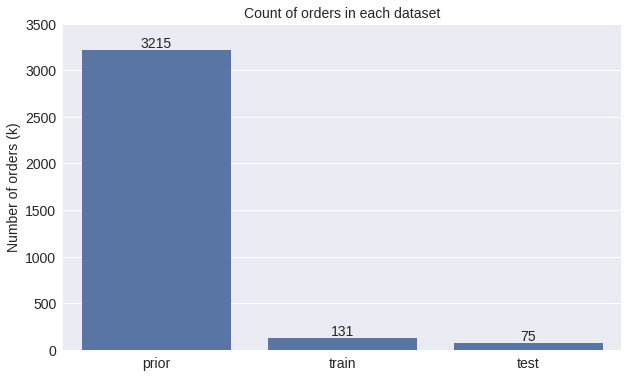

In [17]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(10,6))
ax = sns.barplot(cnt_srs.index, cnt_srs.values/1000,color=color[0])

annotate_bars(ax,fontsize=fs,offset=25)

plt.ylabel('Number of orders (k)',fontsize=14)
plt.title('Count of orders in each dataset',fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylim(0,3500)

Wee see that the vast majority of samples are in the prior set. It is perhaps more interesting to look at this from a customer perspective.

(0, 250)

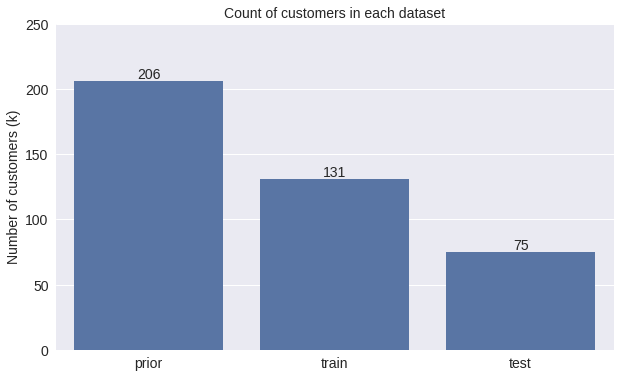

In [18]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs = cnt_srs.reindex(index = ['prior','train','test'])

plt.figure(figsize=(10,6))
ax = sns.barplot(cnt_srs.index, cnt_srs.values/1000,color=color[0])

annotate_bars(ax,fontsize=fs,offset=2)

plt.xlabel("")
plt.ylabel('Number of customers (k)',fontsize=fs)
plt.title('Count of customers in each dataset',fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylim(0,250)

This is more informative. We see that all customers (**206,000**) are represented in the prior set, while **131,000** customers are represented in the training set and **75,000** customer are represented in the test set.

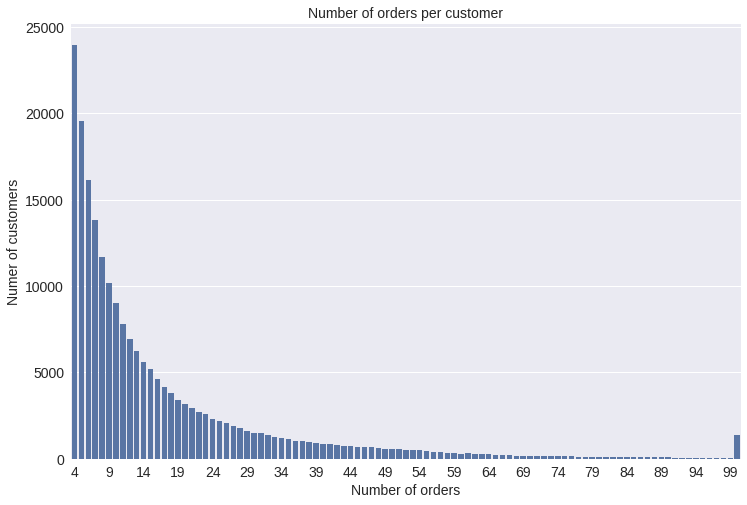

In [19]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
ax = sns.barplot(cnt_srs.index, cnt_srs.values, color=color[0])

plt.title("Number of orders per customer",fontsize=fs)
plt.ylabel('Numer of customers', fontsize=fs)
plt.xlabel('Number of orders', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# Set every 5th label to visible
for label in ax.xaxis.get_ticklabels():
    label.set_visible(False)
for label in ax.xaxis.get_ticklabels()[::5]:
    label.set_visible(True)

If we print out the number of orders per customer we see an interesting long tail distribution. As specified in the description, we see that we are provided with 4 to 100 orders per customers. Also, it seems that the data is "capped" at 100 customers, giving the sudden spike in the distribution.

(0, 700)

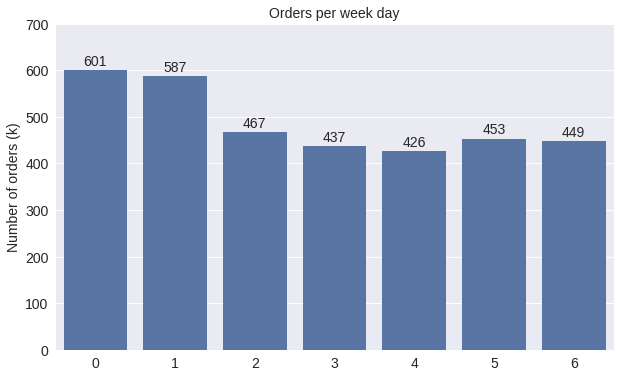

In [20]:
cnt_srs = orders_df.groupby("order_dow")['order_id'].aggregate('count')

plt.figure(figsize=(10,6))
ax = sns.barplot(cnt_srs.index, cnt_srs.values/1000,color=color[0])

annotate_bars(ax,fontsize=fs,offset=10)

plt.xlabel("")
plt.ylabel('Number of orders (k)',fontsize=fs)
plt.title('Orders per week day',fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylim(0,700)

If we look at the number of orders per day of the week, we see that the frequency is higher on day Saturday and Sunday (0 and 1), while stable at a lower level for day 2-6. It definitly seems to be some form of weekly trend.

(0, 400)

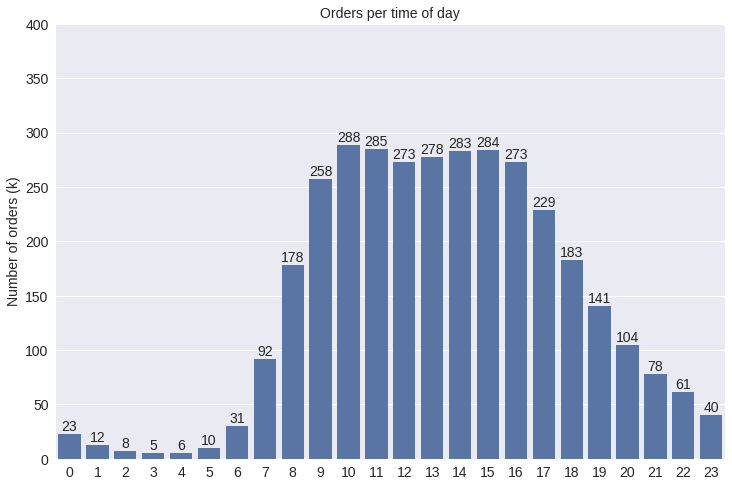

In [21]:
cnt_srs = orders_df.groupby("order_hour_of_day")['order_id'].aggregate('count')

plt.figure(figsize=(12,8))
ax = sns.barplot(cnt_srs.index, cnt_srs.values/1000,color=color[0])

annotate_bars(ax,fontsize=fs,offset=3)

plt.xlabel("")
plt.ylabel('Number of orders (k)',fontsize=fs)
plt.title('Orders per time of day',fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylim(0,400)

Also, if we look at the daily distribution of orders, we see that the activity is highest from 10 to 16 and decline during the night (perhaps not super-surprising).

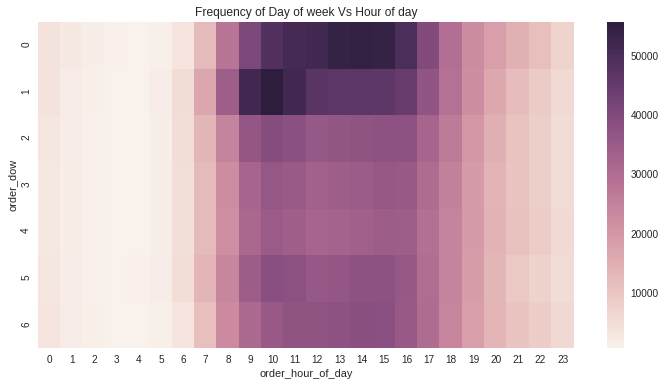

In [22]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")

If we look at the distribution on a weekly and hourly basis, we see that the activity is highest on Saturday afternoon and Sunday morning.

(0, 400)

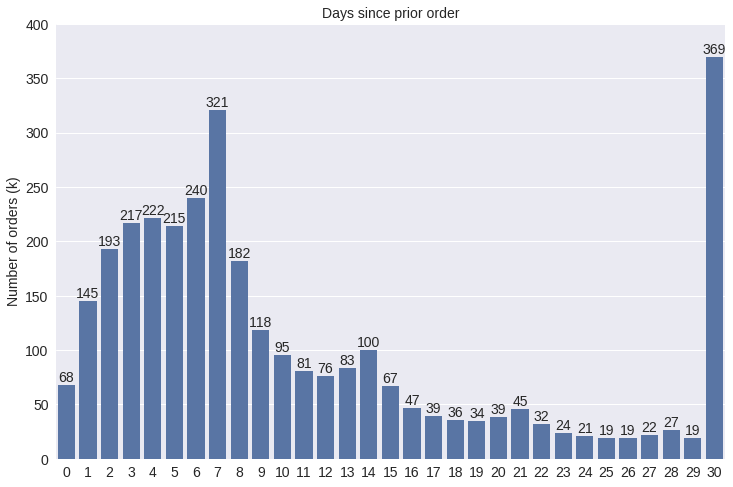

In [23]:
cnt_srs = orders_df.groupby("days_since_prior_order")['order_id'].aggregate('count')
cnt_srs.index = cnt_srs.index.astype(int)

plt.figure(figsize=(12,8))
ax = sns.barplot(cnt_srs.index, cnt_srs.values/1000,color=color[0])

annotate_bars(ax,fontsize=fs,offset=3)

plt.xlabel("")
plt.ylabel('Number of orders (k)',fontsize=fs)
plt.title('Days since prior order',fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylim(0,400)

We also see an interesting trend if we look at the days since previous order. First, we see a peak around 7 days which indicates that many people do weekly purchases. Further, it seems like the data is "capped" at 30 days indicated by the major peak we can see in the plot.

### Re-orders
Another interesting trend we want to look for in the data is how many products are re-ordered vs. ordered for the first time. This is very important since the aim of the competition is only to predict the products that are re-ordered.

In [24]:
# percentage of re-orders in prior set #
print("Fraction of re-orders in the prior set:",order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0])

Fraction of re-orders in the prior set: 0.589697466792


In [25]:
# percentage of re-orders in train set #
print("Fraction of re-orders in the train set:",order_products_train_df.reordered.sum() / order_products_train_df.shape[0])

Fraction of re-orders in the train set: 0.598594412751


The fraction of reordered products is similar in the training set and the prior set at around $59\%$. Let's see how many orders in the training set and prior set that have $0$ re-ordered items.

In [26]:
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
print("Fraction of orders without re-orders in prior set",grouped_df.reordered.value_counts()[0] / grouped_df.shape[0])

grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
print("Fraction of orders without re-orders in train set",grouped_df.reordered.value_counts()[0] / grouped_df.shape[0])

Fraction of orders without re-orders in prior set 0.120848593133
Fraction of orders without re-orders in train set 0.0655595271666


Here, we see that more orders in the prior set have $0$ re-ordered items. This is not that strange since we now that the prior set will include the first order of the customer that by definition have $0$ re-ordered items.

Now, we look at the distribution of products in the market baskets that are re-ordered.

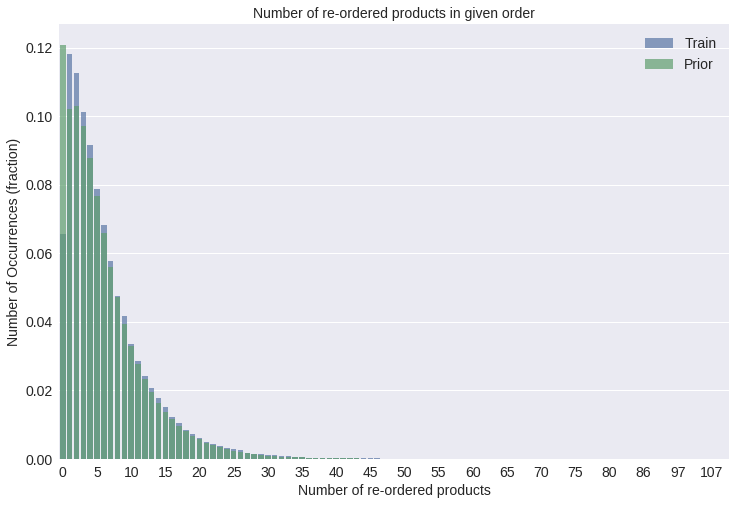

In [27]:
grouped_df_train = order_products_train_df.groupby(["order_id"])["reordered"].aggregate("sum").reset_index()
cnt_srs_train = grouped_df_train.reordered.value_counts()/grouped_df_train.reordered.value_counts().sum()

grouped_df_prior = order_products_prior_df.groupby(["order_id"])["reordered"].aggregate("sum").reset_index()
cnt_srs_prior = grouped_df_prior.reordered.value_counts()/grouped_df_prior.reordered.value_counts().sum()

plt.figure(figsize=(12,8))
ax = sns.barplot(cnt_srs_train.index, cnt_srs_train.values,color=color[0],alpha=0.7,label="Train")
ax = sns.barplot(cnt_srs_prior.index, cnt_srs_prior.values,color=color[1],alpha=0.7,label="Prior")
plt.legend(fontsize=fs)

plt.ylabel('Number of Occurrences (fraction)', fontsize=fs)
plt.xlabel('Number of re-ordered products', fontsize=fs)
plt.title("Number of re-ordered products in given order",fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# Set every 5th label to visible
for label in ax.xaxis.get_ticklabels():
    label.set_visible(False)
for label in ax.xaxis.get_ticklabels()[::5]:
    label.set_visible(True)

We see that a the number of re-ordered products is given by a long-tail distribution for both train and prior.

### Products

Now, let's look at the different products that customers buy.

First, we look at the top 20 products found in the prior set.

In [28]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


We see a lot of fruits and vegetables on the list. Let's also take a closer look at the most popular aisles.

(0, 4000)

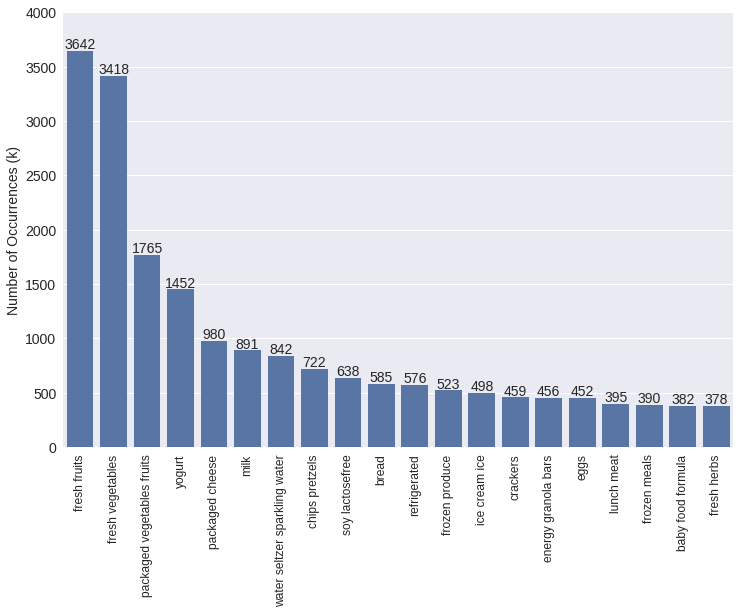

In [29]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
ax = sns.barplot(cnt_srs.index, cnt_srs.values/1000, color=color[0])
annotate_bars(ax,fontsize=fs,offset=20)

plt.ylabel('Number of Occurrences (k)', fontsize=fs)
plt.xticks(rotation='vertical',fontsize=12)
plt.yticks(fontsize=fs)

plt.ylim(0,4000)

We see that fresh fruits and fresh vegetables are the clear winners.

Now, let's look at the most popular departments.

(0, 10000)

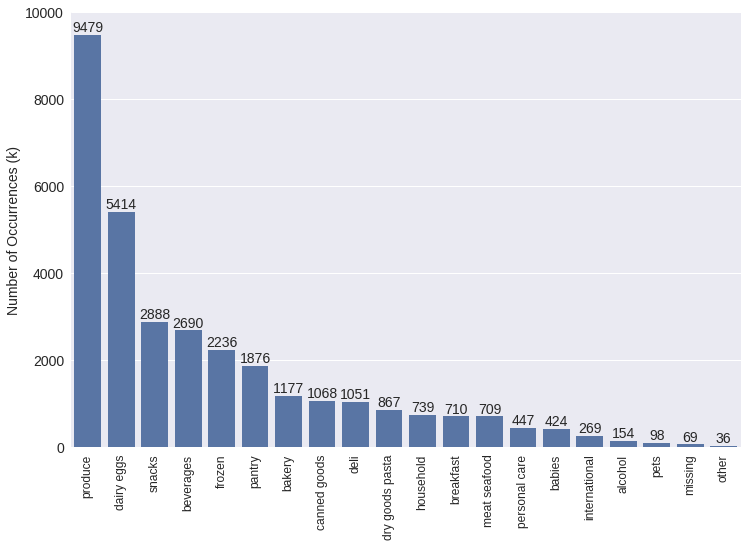

In [30]:
cnt_srs = order_products_prior_df['department'].value_counts().head(20)

plt.figure(figsize=(12,8))
ax = sns.barplot(cnt_srs.index, cnt_srs.values/1000, color=color[0])
annotate_bars(ax,fontsize=fs,offset=70)

plt.ylabel('Number of Occurrences (k)', fontsize=fs)
plt.xticks(rotation='vertical',fontsize=12)
plt.yticks(fontsize=fs)

plt.ylim(0,10000)

Here, we see that produce is the department with most orders.

Another interesting aspect to investigate is the re-order ratio of different products, aisles and department. Let's use the re-order ratio of departments as an example.

(array([ 0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ]),
 <a list of 10 Text yticklabel objects>)

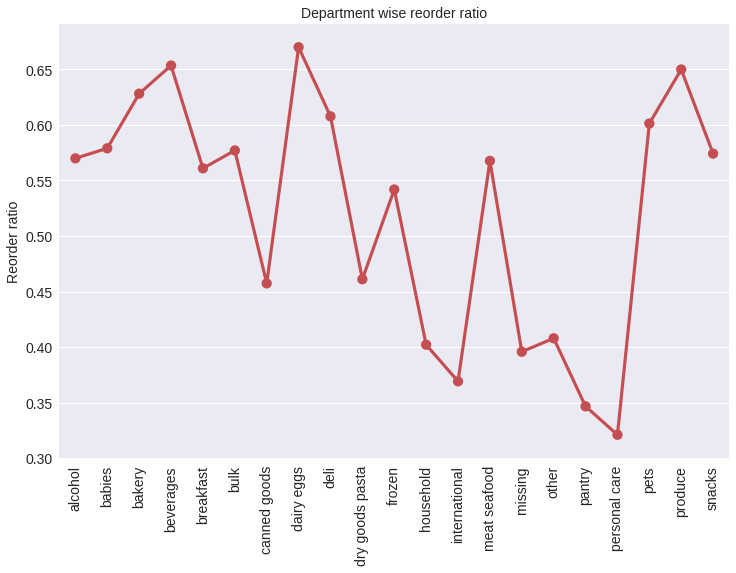

In [31]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=fs)
plt.title("Department wise reorder ratio", fontsize=fs)
plt.xticks(rotation='vertical',fontsize=fs)
plt.yticks(fontsize=fs)

We see that the reorder rate varies a lot between different departments with highest values for departments like diary eggs and produce.

Another aspect that might be interesting is the relationship between reorder ratio and add-to-cart ratio.

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


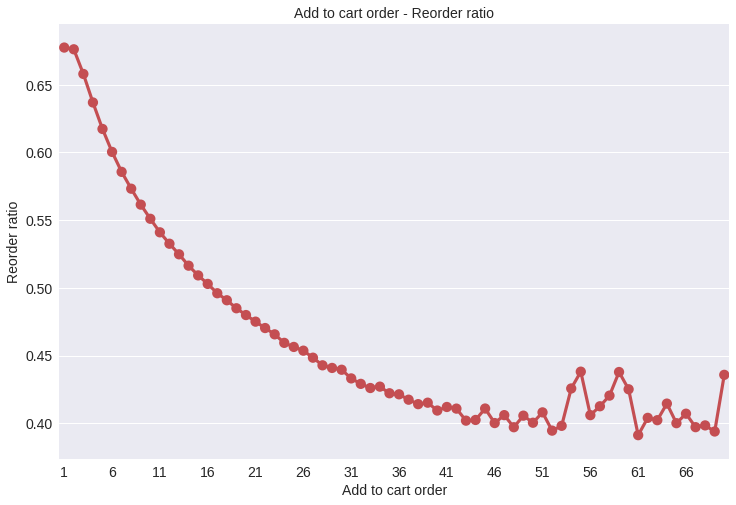

In [30]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].loc[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
ax = sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=fs)
plt.xlabel('Add to cart order', fontsize=fs)
plt.title("Add to cart order - Reorder ratio", fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# Set every 5th label to visible
for label in ax.xaxis.get_ticklabels():
    label.set_visible(False)
for label in ax.xaxis.get_ticklabels()[::5]:
    label.set_visible(True)

We see that products that are put early in the market basket have a higher probability of being re-ordered.

Now, let's look if we have the same interesting relationship for re-order ratio and day of week and time.

(0.5, 0.7)

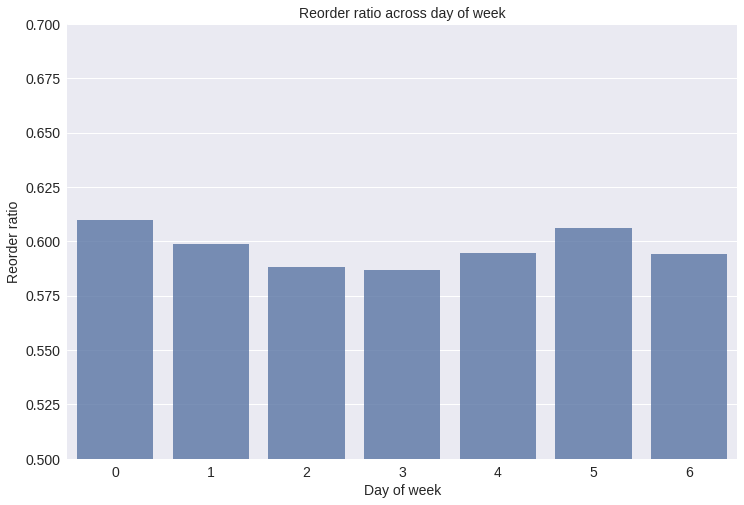

In [32]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[0])
plt.ylabel('Reorder ratio', fontsize=fs)
plt.xlabel('Day of week', fontsize=fs)
plt.title("Reorder ratio across day of week", fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylim(0.5, 0.7)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5]),
 <a list of 7 Text yticklabel objects>)

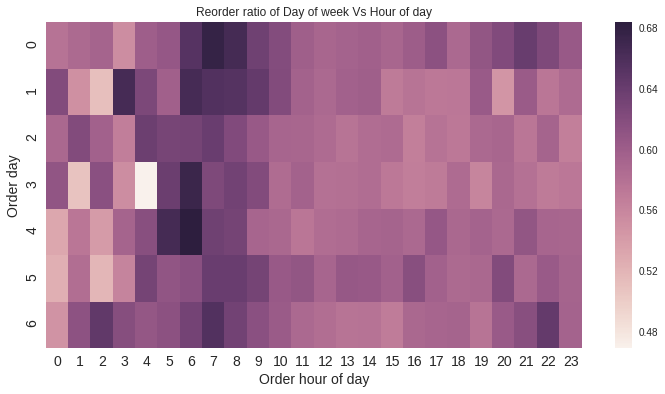

In [33]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")

plt.xlabel("Order hour of day",fontsize=fs)
plt.ylabel("Order day",fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

There seems to be less clearer relationship between these variables. 

## Conclusion

Overall, there is definitly some interesting trends. Looking forward to giving this competition a first shot!